<div align="center">

### Name: Zayd Krunz
### <span style="color: #8C1515;">Stanford Pre-Collegiate Summer Institutes (Intro to Machine Learning)</span>
</div>

#### Project Title: Predictive Maintenance Using Machine Learning to Forecast Failure
#### [AI4I 2020 Predictive Maintenance Dataset](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset)

#### Description of Dataset:
"The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry. Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge."

**Number of Instances:** 10,000<br>
**Number of Features:** 14<br>
**Variables:**

| Variable            | Type        | Notes                                                        |
|---------------------|-------------|--------------------------------------------------------------|
| UID                 | Integer     | Removed for redundancy                                       |
| Product ID          | Categorical | Removed for redundancy                                       |
| Type                | Categorical | One-hot encoded                                              |
| Air temperature     | Continuous  |                                                              |
| Process temperature | Continuous  |                                                              |
| Rotational speed    | Integer     |                                                              |
| Torque              | Continuous  |                                                              |
| Tool wear           | Integer     |                                                              |
| Machine failure     | Integer     | Target/Dependent Variable                                    |
| TWF                 | Integer     | Removed due to binary classification                         |
| HDF                 | Integer     | Removed due to binary classification                         |
| PWF                 | Integer     | Removed due to binary classification                         |
| OSF                 | Integer     | Removed due to binary classification                         |
| RNF                 | Integer     | Removed due to binary classification                         |

# Data Loading and Initial Prep

This section loads the dataset and performs initial checks and explorations.

In [108]:
!pip install phik -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import scipy.stats as stats
from scipy.stats import skew, norm, probplot, zscore
from matplotlib.pyplot import boxplot
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import shap
from phik import resources, report
from phik.report import plot_correlation_matrix

In [109]:
df = pd.read_csv('https://raw.githubusercontent.com/ShrootBuck/stanford-predictive-maintenance/refs/heads/main/ai4i2020.csv')

In [110]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Feature Engineering

In this section, new features are created from existing ones to potentially improve the model's performance.

In [111]:
# Remove useless stuff such as UID
del df["UDI"]
del df["Product ID"]

In [112]:
# Remove type of failure classes
# Otherwise, model will likely learn "if TWF = 1, MachineFailure = 1" (and be entirely useless)
del df["TWF"]
del df["HDF"]
del df["PWF"]
del df["OSF"]
del df["RNF"]

In [113]:
# Rename badly named fields
df.rename(columns={'Rotational speed [rpm]': 'RPM', 'Torque [Nm]': 'Torque', 'Machine failure': 'Failure',
                   'Air temperature [K]': 'Air Temperature', 'Process temperature [K]': 'Process Temperature', 'Tool wear [min]': 'Tool Wear'}, inplace=True)

In [114]:
# Add potentially useful stuff
df['Temperature Difference'] = df['Process Temperature'] - df['Air Temperature']
df['Power'] = df['Torque'] * df['RPM']

# A worn out tool with high torque will probably fail
df['Wear_x_Torque'] = df['Tool Wear'] * df['Torque']

In [115]:
df.head()

,Type,Air Temperature,Process Temperature,RPM,Torque,Tool Wear,Failure,Temperature Difference,Power,Wear_x_Torque
0,M,298.1,308.6,1551,42.8,0,0,10.5,66382.8,0.0
1,L,298.2,308.7,1408,46.3,3,0,10.5,65190.4,138.9
2,L,298.1,308.5,1498,49.4,5,0,10.4,74001.2,247.0
3,L,298.2,308.6,1433,39.5,7,0,10.4,56603.5,276.5
4,L,298.2,308.7,1408,40.0,9,0,10.5,56320.0,360.0


In [116]:
df.tail()

,Type,Air Temperature,Process Temperature,RPM,Torque,Tool Wear,Failure,Temperature Difference,Power,Wear_x_Torque
9995,M,298.8,308.4,1604,29.5,14,0,9.6,47318.0,413.0
9996,H,298.9,308.4,1632,31.8,17,0,9.5,51897.6,540.6
9997,M,299.0,308.6,1645,33.4,22,0,9.6,54943.0,734.8
9998,H,299.0,308.7,1408,48.5,25,0,9.7,68288.0,1212.5
9999,M,299.0,308.7,1500,40.2,30,0,9.7,60300.0,1206.0


In [117]:
df.shape

(10000, 10)

In [118]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air Temperature,10000.0,300.00493,2.000259,295.3,298.30,300.10,301.50,304.5
Process Temperature,10000.0,310.00556,1.483734,305.7,308.80,310.10,311.10,313.8
RPM,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.00,1612.00,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.20,40.10,46.80,76.6
Tool Wear,10000.0,107.95100,63.654147,0.0,53.00,108.00,162.00,253.0
Failure,10000.0,0.03390,0.180981,0.0,0.00,0.00,0.00,1.0
Temperature Difference,10000.0,10.00063,1.001094,7.6,9.30,9.80,11.00,12.1
Power,10000.0,59967.14704,10193.093881,10966.8,53105.40,59883.90,66873.75,99980.4
Wear_x_Torque,10000.0,4314.66455,2826.567692,0.0,1963.65,4012.95,6279.00,16497.0


In [119]:
# Make the visualization nice for my poster

stats = df.describe().T

# Round 'mean' and 'std' to 2 decimals and make 'count' an integer
stats[['mean', 'std']] = stats[['mean', 'std']].round(2)
stats['count'] = stats['count'].astype(int)

stats

,count,mean,std,min,25%,50%,75%,max
Air Temperature,10000,300.00,2.00,295.3,298.30,300.10,301.50,304.5
Process Temperature,10000,310.01,1.48,305.7,308.80,310.10,311.10,313.8
RPM,10000,1538.78,179.28,1168.0,1423.00,1503.00,1612.00,2886.0
Torque,10000,39.99,9.97,3.8,33.20,40.10,46.80,76.6
Tool Wear,10000,107.95,63.65,0.0,53.00,108.00,162.00,253.0
Failure,10000,0.03,0.18,0.0,0.00,0.00,0.00,1.0
Temperature Difference,10000,10.00,1.00,7.6,9.30,9.80,11.00,12.1
Power,10000,59967.15,10193.09,10966.8,53105.40,59883.90,66873.75,99980.4
Wear_x_Torque,10000,4314.66,2826.57,0.0,1963.65,4012.95,6279.00,16497.0


In [120]:
df[df.duplicated()].count() # Nice, 0 dupes

,0
Type,0
Air Temperature,0
Process Temperature,0
RPM,0
Torque,0
Tool Wear,0
Failure,0
Temperature Difference,0
Power,0
Wear_x_Torque,0


In [121]:
# Commenting out cause this doesnt work with this type of dataset

# # Function to return suspiciously high values for each variable
# def get_high_outliers(df, n_std=3):
#     high_outliers = {}
#     numeric_cols = df.select_dtypes(include=[np.number])

#     for col in numeric_cols.columns:
#         mean_val = numeric_cols[col].mean()
#         std_val = numeric_cols[col].std()
#         upper_bound = mean_val + n_std * std_val
#         outlier_vals = df[df[col] > upper_bound][col]

#         if not outlier_vals.empty:
#             high_outliers[col] = outlier_vals

#     return high_outliers

# # Get high outliers using 3×std
# high_outlier_dict = get_high_outliers(df, n_std=3)

# # View results
# for col, vals in high_outlier_dict.items():
#     print(f"\n {col} values > mean + 3×std:")
#     print(vals.to_string(index=False))

In [122]:
# Select only numeric features
numeric_variables = df.select_dtypes(include=[np.number])

# Calculate skewness for each numeric feature
skewness = numeric_variables.apply(lambda x: skew(x.dropna()))
skewed_variables = skewness[abs(skewness) > 0.75]

# Display results
print("Skewed Variables (|skew| > 0.75):")
print(skewed_variables)

Skewed Variables (|skew| > 0.75):
RPM        1.992872
Failure    5.151079
dtype: float64


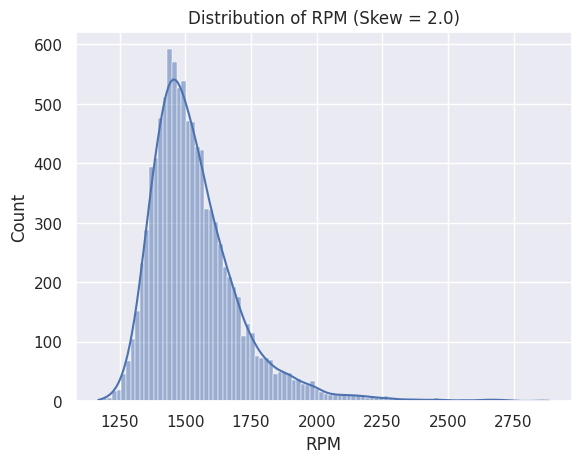

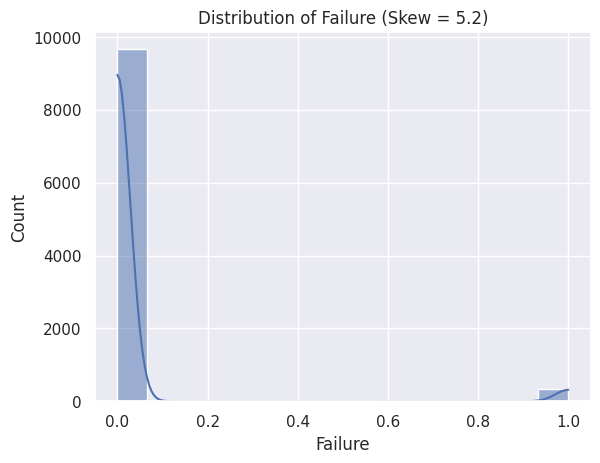

In [123]:
# Visualize skewed variables

for feature in skewed_variables.index:
    plt.figure()
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature} (Skew = {skewness[feature]:.1f})')
    plt.show();

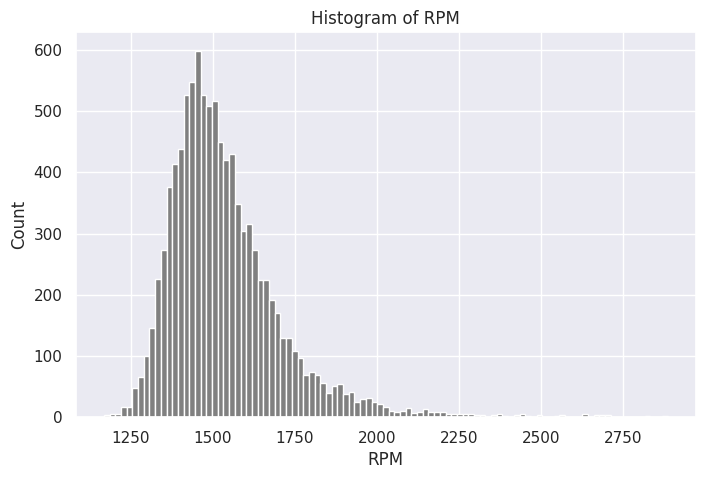

In [124]:
sns.set_theme(style = "darkgrid")

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(df["RPM"], color="grey", bins=99)
plt.xlabel ("RPM")
plt.ylabel("Count")
plt.title("Histogram of RPM")
plt.show()

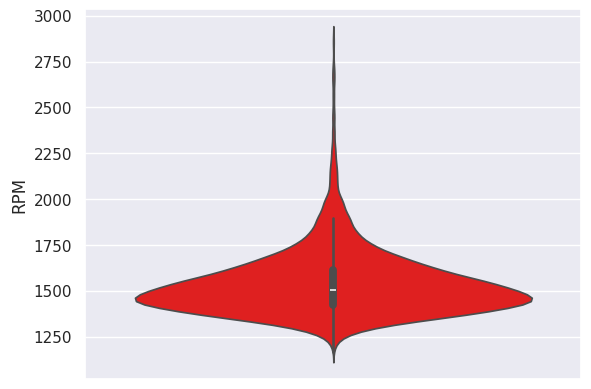

In [125]:
sns.set_theme(style="darkgrid")

sns.violinplot(df["RPM"], color = "red")
plt.show()

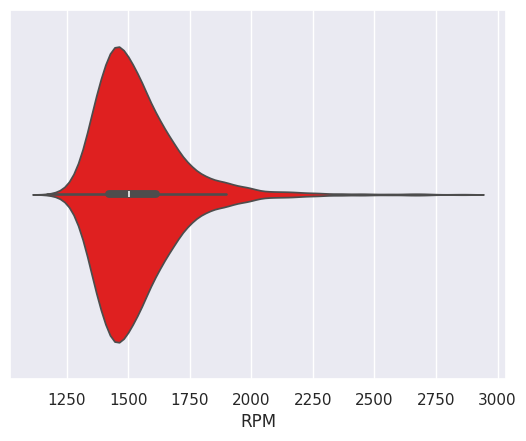

In [126]:
sns.set_theme(style="darkgrid")

sns.violinplot(x=df["RPM"], color = "red")
plt.show()

In [127]:
# Pearson's Correlation (r)
df.corr(numeric_only=True)

,Air Temperature,Process Temperature,RPM,Torque,Tool Wear,Failure,Temperature Difference,Power,Wear_x_Torque
Air Temperature,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,-0.699583,-0.011474,0.006981
Process Temperature,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,-0.268413,-0.010952,0.006003
RPM,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,-0.016727,-0.805584,-0.331277
Torque,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,0.006690,0.978828,0.377038
Tool Wear,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,-0.007689,-0.003193,0.897520
Failure,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,-0.111676,0.176039,0.190427
Temperature Difference,-0.699583,-0.268413,-0.016727,0.006690,-0.007689,-0.111676,1.000000,0.006694,-0.005051
Power,-0.011474,-0.010952,-0.805584,0.978828,-0.003193,0.176039,0.006694,1.000000,0.368842
Wear_x_Torque,0.006981,0.006003,-0.331277,0.377038,0.897520,0.190427,-0.005051,0.368842,1.000000


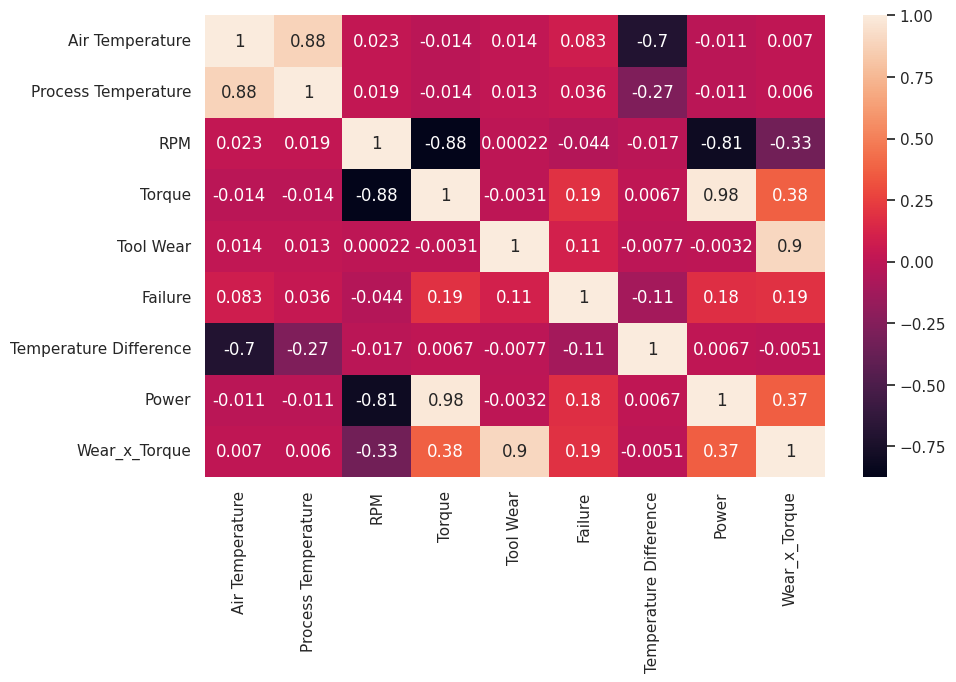

In [128]:
# Pearson's Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True);
plt.show();

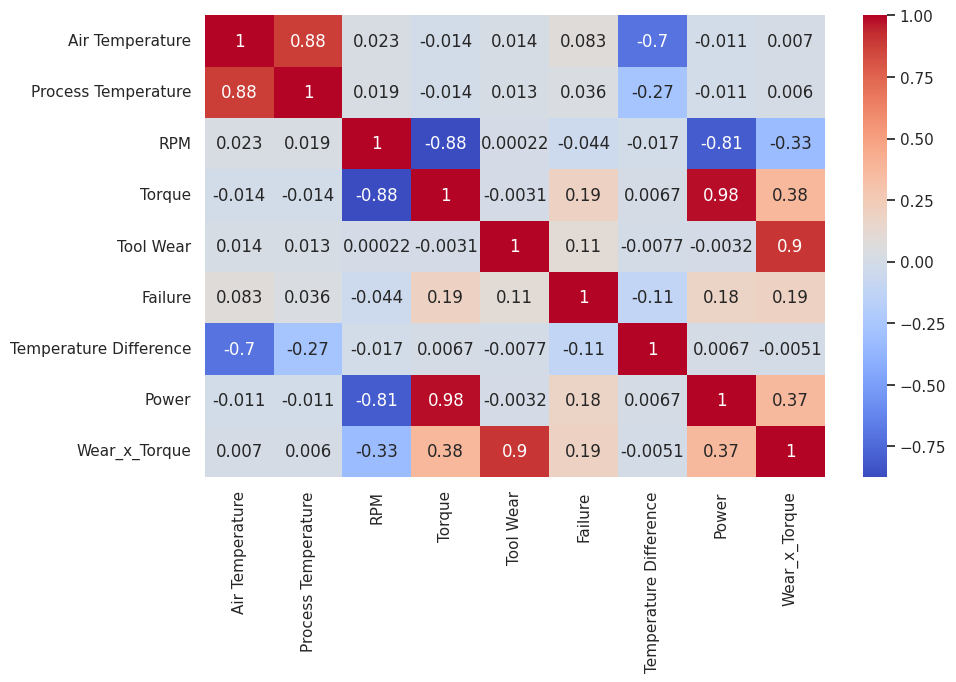

In [129]:
# Pearson's correlation (with heatmap and coolwarm color)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm");
plt.show()

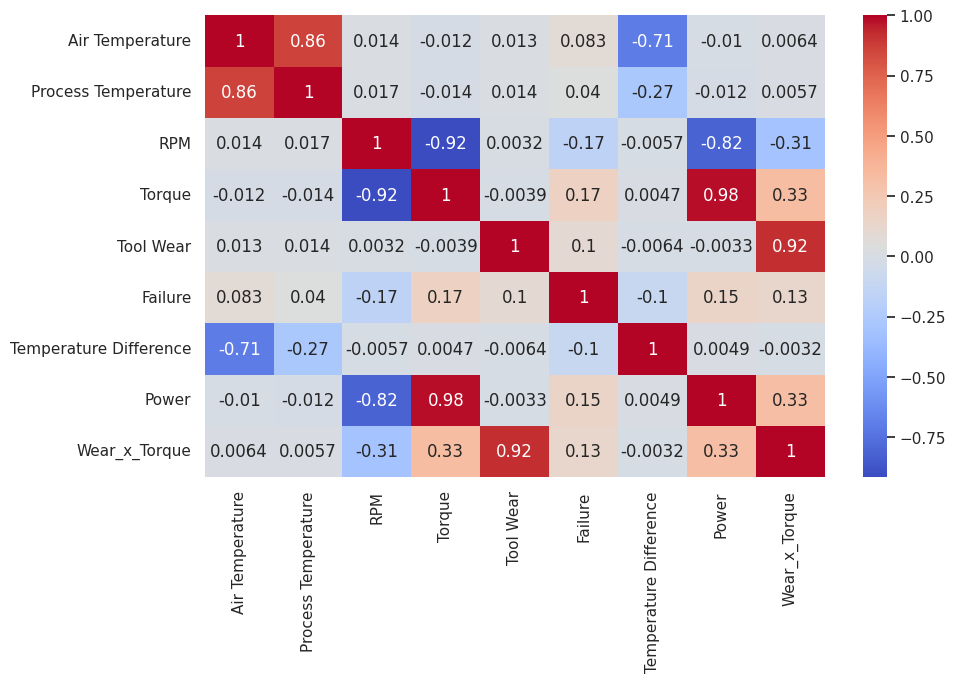

In [130]:
# Spearman's Rank or Spearman's Rho correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, cmap="coolwarm"); # nonparametric correlation
plt.show()

In [131]:
df.phik_matrix()

interval columns not set, guessing: ['Air Temperature', 'Process Temperature', 'RPM', 'Torque', 'Tool Wear', 'Failure', 'Temperature Difference', 'Power', 'Wear_x_Torque']


,Type,Air Temperature,Process Temperature,RPM,Torque,Tool Wear,Failure,Temperature Difference,Power,Wear_x_Torque
Type,1.000000,0.027828,0.022919,0.005016,0.000000,0.000000,0.020646,0.017158,0.000000,0.000000
Air Temperature,0.027828,1.000000,0.923235,0.037658,0.039935,0.111049,0.160864,0.768303,0.000000,0.080493
Process Temperature,0.022919,0.923235,1.000000,0.000000,0.029331,0.131704,0.087284,0.646378,0.024357,0.084544
RPM,0.005016,0.037658,0.000000,1.000000,0.937916,0.000000,0.448734,0.000000,0.919124,0.414142
Torque,0.000000,0.039935,0.029331,0.937916,1.000000,0.000000,0.585491,0.033366,0.974378,0.545747
Tool Wear,0.000000,0.111049,0.131704,0.000000,0.000000,1.000000,0.278363,0.150779,0.026040,0.866334
Failure,0.020646,0.160864,0.087284,0.448734,0.585491,0.278363,1.000000,0.246310,0.561486,0.546505
Temperature Difference,0.017158,0.768303,0.646378,0.000000,0.033366,0.150779,0.246310,1.000000,0.000000,0.104619
Power,0.000000,0.000000,0.024357,0.919124,0.974378,0.026040,0.561486,0.000000,1.000000,0.501407
Wear_x_Torque,0.000000,0.080493,0.084544,0.414142,0.545747,0.866334,0.546505,0.104619,0.501407,1.000000


In [132]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Air Temperature', 'Process Temperature', 'RPM', 'Torque', 'Tool Wear', 'Failure', 'Temperature Difference', 'Power', 'Wear_x_Torque']


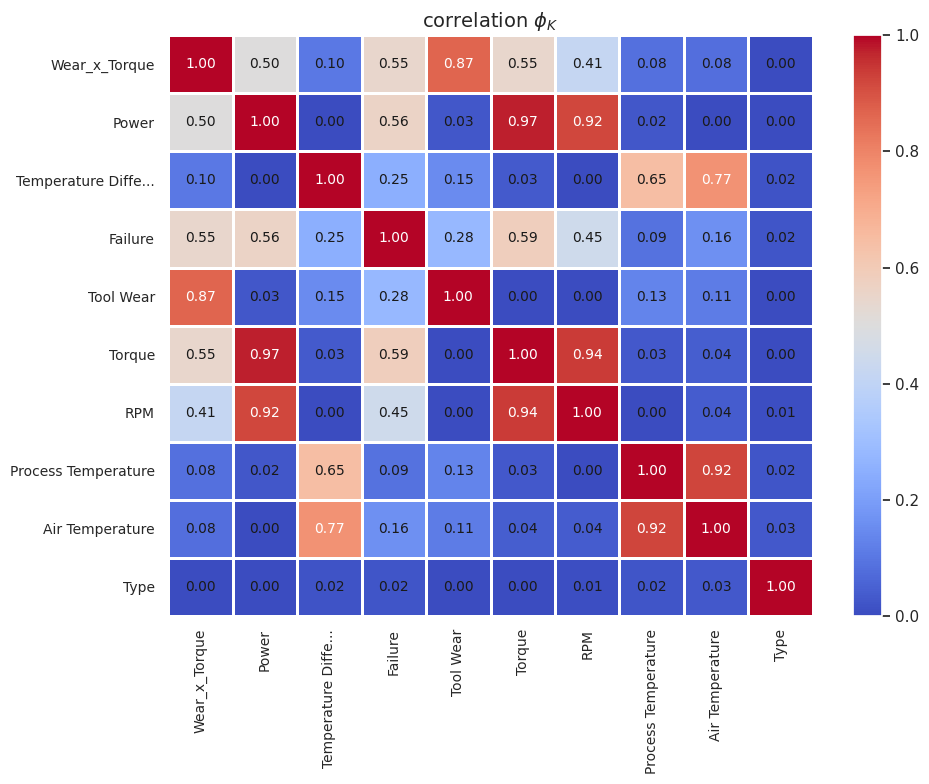

In [133]:
# Presenting Phi K data as a heatmap (credit: Jai Gupta, Stanford SPCS 2023)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title=r"correlation $\phi_K$",
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

# Data Preprocessing

This section handles data preparation for model training, including handling categorical features, splitting data, and scaling.

In [134]:
# IMPORTANT: we have to drop one of the types to avoid multicolinearity
# (Model can still infer Type_H = 1 if Type_L, Type_M = 0,0 )
df_processed = pd.get_dummies(df, columns=['Type'], drop_first=True, dtype=int)
df_processed.head()

,Air Temperature,Process Temperature,RPM,Torque,Tool Wear,Failure,Temperature Difference,Power,Wear_x_Torque,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,10.5,66382.8,0.0,0,1
1,298.2,308.7,1408,46.3,3,0,10.5,65190.4,138.9,1,0
2,298.1,308.5,1498,49.4,5,0,10.4,74001.2,247.0,1,0
3,298.2,308.6,1433,39.5,7,0,10.4,56603.5,276.5,1,0
4,298.2,308.7,1408,40.0,9,0,10.5,56320.0,360.0,1,0


In [135]:
X = df_processed.drop('Failure', axis=1) # All columns EXCEPT the target
y = df_processed['Failure'] # ONLY the target column

# stratify=y is CRITICAL for imbalanced dataset like this one. It makes sure both sets
# get the same proportion of failures

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [136]:
scaler = StandardScaler()

# Learn the scaling parameters from the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# ONLY TRANSFORM TEST DATA USING PARAMS LEARNED FROM TRAINING SET!!!
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation

This section trains and evaluates different machine learning models for the predictive maintenance task.

## Random Forest

This subsection focuses on training and evaluating a Random Forest Classifier.

In [137]:
# Let's see the magic
print("Original training set shape %s" % Counter(y_train))

# Use a Pipeline to chain the scaler and the model together
from sklearn.pipeline import Pipeline as SklearnPipeline

pipe = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

pipe.fit(X_train, y_train)

Original training set shape Counter({0: 7729, 1: 271})


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       1.00      0.71      0.83        68

    accuracy                           0.99      2000
   macro avg       0.99      0.85      0.91      2000
weighted avg       0.99      0.99      0.99      2000



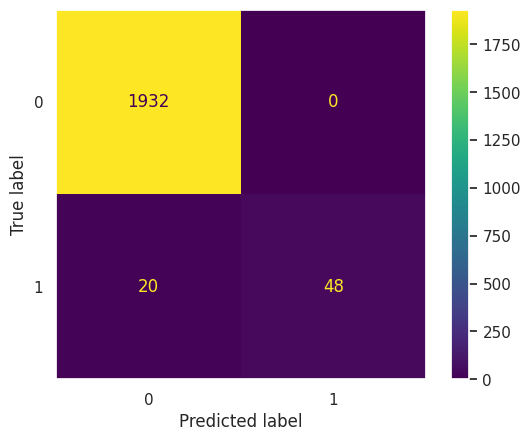

In [138]:
# Make predictions on the test data using the pipeline
y_pred_rf = pipe.predict(X_test) # Use the pipe object here again

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.grid(False)
plt.show()

In [139]:
pipeline = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# I gotta remember to reference parameters using the step name followed by two underscores
param_grid_normal = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid_normal,
                           cv=3,
                           scoring='recall',
                           )

# Fit the grid search to the original training data
grid_search.fit(X_train, y_train)

print("\nBest parameters found: ", grid_search.best_params_)
print("Best F1-score found: ", grid_search.best_score_)

# Use the best model (which is the best pipeline) to make predictions on test set
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

print("\nFinal Classification Report (with tuned model):")
print(classification_report(y_test, y_pred_final))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best F1-score found:  0.8155881155881156

Final Classification Report (with tuned model):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.98      0.76      0.86        68

    accuracy                           0.99      2000
   macro avg       0.99      0.88      0.93      2000
weighted avg       0.99      0.99      0.99      2000



<Axes: >

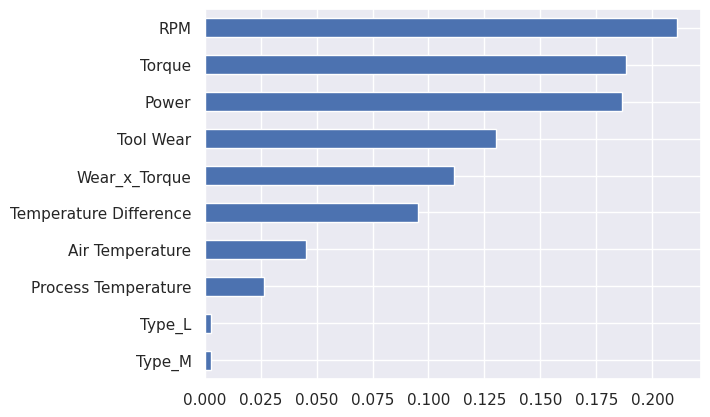

In [140]:
# Feature importances
# Access the classifier step from the pipeline
classifier_model = best_model.named_steps['classifier']

# Now access feature_importances_ from the classifier model
pd.Series(classifier_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')

# Bagging Classifier

This subsection focuses on training and evaluating a Bagging Classifier.


Best parameters found (Tuned Bagging Classifier):  {'classifier__estimator': None, 'classifier__max_features': 1.0, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 50}
Best Recall score found (Tuned Bagging Classifier):  0.8265771265771266

Final Classification Report (Tuned Bagging Classifier):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       1.00      0.74      0.85        68

    accuracy                           0.99      2000
   macro avg       1.00      0.87      0.92      2000
weighted avg       0.99      0.99      0.99      2000



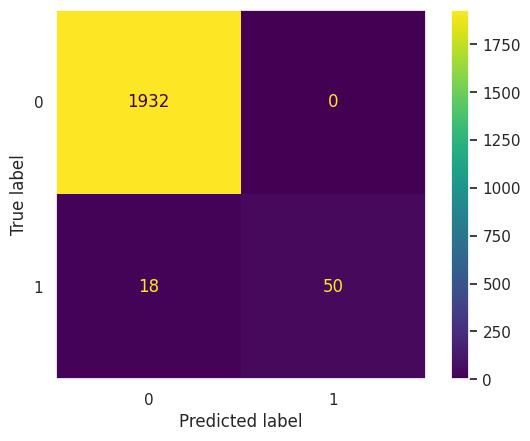

In [141]:
bagging_pipeline = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', BaggingClassifier())
])


bagging_pipeline.fit(X_train, y_train)

param_grid_bagging = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_samples': [0.5, 0.7, 1.0],
    'classifier__max_features': [0.5, 0.7, 1.0],
    'classifier__estimator': [None, LogisticRegression()]
}

# Using GridSearchCV for tuning
grid_search_bagging = GridSearchCV(estimator=bagging_pipeline,
                                   param_grid=param_grid_bagging,
                                   cv=3,
                                   scoring='recall',
                                   )

grid_search_bagging.fit(X_train, y_train)

print("\nBest parameters found (Tuned Bagging Classifier): ", grid_search_bagging.best_params_)
print("Best Recall score found (Tuned Bagging Classifier): ", grid_search_bagging.best_score_)


best_bagging_model = grid_search_bagging.best_estimator_
y_pred_tuned_bagging = best_bagging_model.predict(X_test)

print("\nFinal Classification Report (Tuned Bagging Classifier):")
print(classification_report(y_test, y_pred_tuned_bagging))

cm_tuned_bagging = confusion_matrix(y_test, y_pred_tuned_bagging)
disp_tuned_bagging = ConfusionMatrixDisplay(confusion_matrix=cm_tuned_bagging)
disp_tuned_bagging.plot()
plt.grid(False)
plt.show()

## Logistic Regression

This subsection focuses on training and evaluating a Logistic Regression model as a baseline.


Classification Report (Logistic Regression Baseline):
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1932
           1       0.16      0.81      0.27        68

    accuracy                           0.85      2000
   macro avg       0.58      0.83      0.59      2000
weighted avg       0.96      0.85      0.89      2000



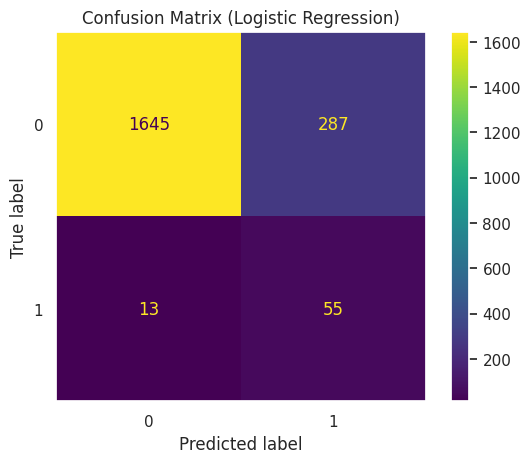

In [142]:
log_reg = LogisticRegression(class_weight='balanced')

pipe_log_reg = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', log_reg)
])

pipe_log_reg.fit(X_train, y_train)

y_pred_log_reg = pipe_log_reg.predict(X_test)

print("\nClassification Report (Logistic Regression Baseline):")
print(classification_report(y_test, y_pred_log_reg))
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
disp_log_reg.plot()
plt.grid(False)
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

## XGBoost

This subsection focuses on training and evaluating an XGBoost Classifier.

In [143]:
pipe_xgb = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=Counter(y_train)[0] / Counter(y_train)[1])) # Use scale_pos_weight
])

# Create a parameter grid specific to XGBoost
# These are some of the most common ones to tune
# I should probably experiment more if I have more time
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(estimator=pipe_xgb,
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='recall',
                               )

grid_search_xgb.fit(X_train, y_train)


print("\nBest XGBoost params: ", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("\nFinal Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))


Best XGBoost params:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Final Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1932
           1       0.36      0.93      0.52        68

    accuracy                           0.94      2000
   macro avg       0.68      0.93      0.75      2000
weighted avg       0.98      0.94      0.95      2000



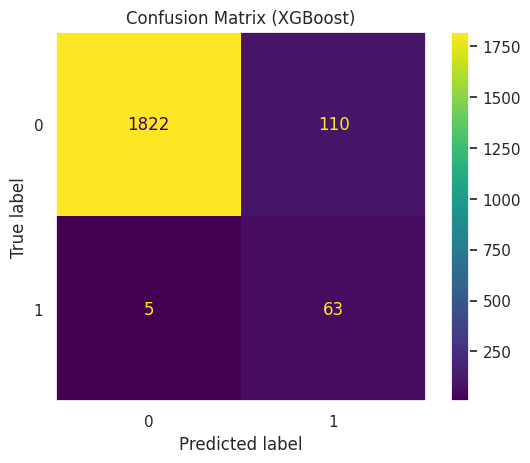

In [144]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.grid(False)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

## Support Vector Classifier (SVC)

This subsection focuses on training and evaluating a Support Vector Classifier.


Best SVC params:  {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

Final Classification Report (SVC):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1932
           1       0.32      0.88      0.47        68

    accuracy                           0.93      2000
   macro avg       0.66      0.91      0.71      2000
weighted avg       0.97      0.93      0.95      2000



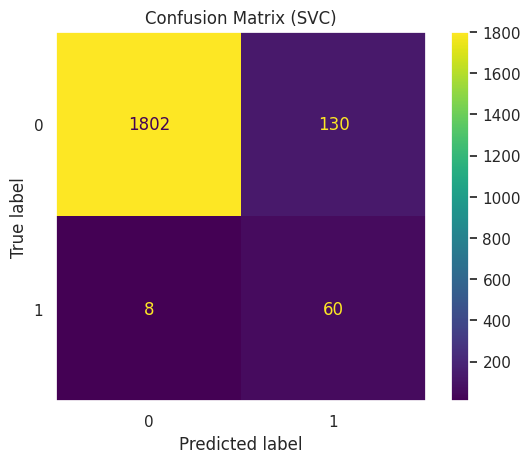

In [145]:
pipe_svc = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, class_weight='balanced'))
])

# Supposed to be balanced defaults
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf']
}

grid_search_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5,
                              scoring='recall',
                               #  scoring='f1',
                               )
grid_search_svc.fit(X_train, y_train)

print("\nBest SVC params: ", grid_search_svc.best_params_)
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

print("\nFinal Classification Report (SVC):")
print(classification_report(y_test, y_pred_svc))

cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot()
plt.grid(False)
plt.title("Confusion Matrix (SVC)")
plt.show()

## Basic Decision Tree

This subsection focuses on training and evaluating a Basic Decision Tree.


Best Decision Tree params:  {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best Decision Tree Recall score found:  0.8486868686868687

Final Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.48      0.84      0.61        68

    accuracy                           0.96      2000
   macro avg       0.74      0.90      0.80      2000
weighted avg       0.98      0.96      0.97      2000



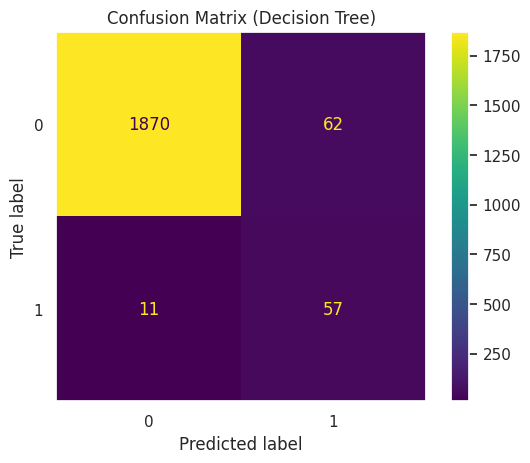

In [146]:
pipe_dt = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(class_weight='balanced'))
])

param_grid_dt = {
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(estimator=pipe_dt,
                              param_grid=param_grid_dt,
                              cv=5,
                              scoring='recall',
                              )

grid_search_dt.fit(X_train, y_train)

print("\nBest Decision Tree params: ", grid_search_dt.best_params_)
print("Best Decision Tree Recall score found: ", grid_search_dt.best_score_)

best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# Evaluate the best Decision Tree model
print("\nFinal Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()
plt.title("Confusion Matrix (Decision Tree)")
plt.grid(False)
plt.show()

## K-Nearest Neighbors (k-NN)

This code cell implements and evaluates a K-Nearest Neighbors (k-NN) Classifier.


In [147]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    # Try a wider range of neighbors to fix my overfitting issue
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}


grid_search_knn = GridSearchCV(estimator=pipe_knn,
                               param_grid=param_grid_knn,
                               cv=5,
                               scoring='recall',
                               )

grid_search_knn.fit(X_train, y_train)

print("\nBest KNN params: ", grid_search_knn.best_params_)
print("Best KNN F1-score found: ", grid_search_knn.best_score_)

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)


print("\nFinal Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn))


Best KNN params:  {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best KNN F1-score found:  0.4134680134680135

Final Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1932
           1       0.74      0.41      0.53        68

    accuracy                           0.97      2000
   macro avg       0.86      0.70      0.76      2000
weighted avg       0.97      0.97      0.97      2000



## Neural Network (Keras, through TensorFlow)

This subsection focuses on building, training, and evaluating a Neural Network using Keras.

In [148]:
# Keras needs my scaled data, so must create it explicitly
scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train)
X_test_scaled_nn = scaler_nn.transform(X_test)

# Calculate class weights
# This helps the model pay more attention to the minority class during training
# Since my dataset has only like 3% Failure
class_weights = {0: 1, 1: Counter(y_train)[0] / Counter(y_train)[1]}
print("Class weights:", class_weights)


final_boss_nn = Sequential([
    Dense(128, input_shape=(X_train_scaled_nn.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

final_boss_nn.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

final_boss_nn.summary()

history = final_boss_nn.fit(X_train_scaled_nn, y_train,
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[early_stopping, reduce_lr],
                            class_weight=class_weights,
                            verbose=1)

y_pred_prob = final_boss_nn.predict(X_test_scaled_nn)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nFinal Classification Report (Final Boss NN):")
print(classification_report(y_test, y_pred))

Class weights: {0: 1, 1: 28.52029520295203}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7557 - loss: 1.4728 - precision: 0.0608 - recall: 0.4695 - val_accuracy: 0.7131 - val_loss: 0.6449 - val_precision: 0.1006 - val_recall: 0.9444 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7442 - loss: 0.9252 - precision: 0.0795 - recall: 0.7457 - val_accuracy: 0.7594 - val_loss: 0.5785 - val_precision: 0.1178 - val_recall: 0.9444 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7771 - loss: 0.8207 - precision: 0.1198 - recall: 0.8550 - val_accuracy: 0.7919 - val_loss: 0.5190 - val_precision: 0.1319 - val_recall: 0.9259 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8073 - loss: 0.7963 - precision: 0.1263 - recall: 0.8531 - val_accuracy: 0.7994 - val_loss: 0.4921 - val_precision: 0.1382 - val_recall: 0.9444 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accur

# Model Interpretation (SHAP)

This section uses SHAP values to interpret the predictions of the best-performing model. This uses the F1 score (instead of the business-case recall) for a better intuition of which features may heavily impact a machine's failure.

Random Forest F1 Score: 0.8595
Logistic Regression F1 Score: 0.2683
XGBoost F1 Score: 0.5228
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network F1 Score: 0.3038
KNN F1 Score: 0.5283
SVC F1 Score: 0.4651

Best model based on F1 score for class 1: Random Forest with F1 score: 0.8595

Performing SHAP analysis for Random Forest...
Shape of shap_values_to_plot before plotting: (2000, 10)
Shape of X_to_plot before plotting: (2000, 10)


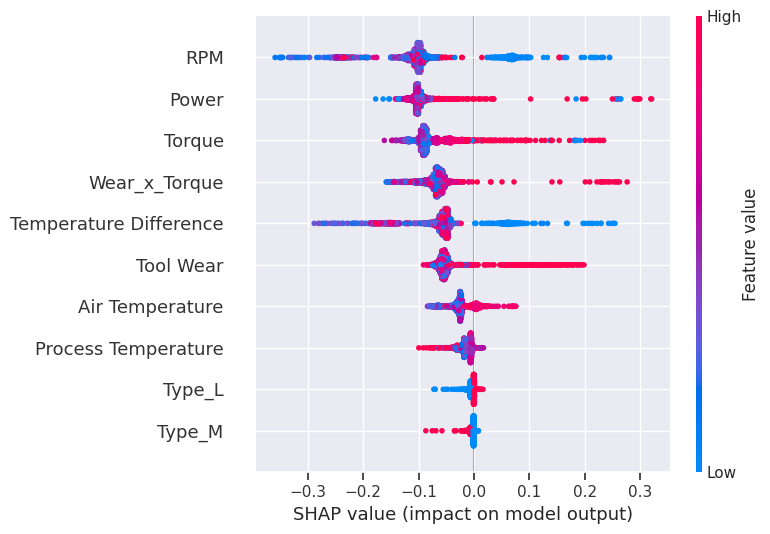

In [149]:
models = {
    'Random Forest': grid_search.best_estimator_,
    'Logistic Regression': pipe_log_reg,
    'XGBoost': grid_search_xgb.best_estimator_,
    'Neural Network': final_boss_nn,
    'KNN': grid_search_knn.best_estimator_,
    'SVC': grid_search_svc.best_estimator_
}

best_f1_score = 0
best_model_name = None
best_final_model = None

for name, model in models.items():
    if isinstance(model, SklearnPipeline):
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['1']['f1-score']
    elif name == 'Neural Network':
        y_pred_prob_nn = model.predict(X_test_scaled_nn)
        y_pred = (y_pred_prob_nn > 0.5).astype(int)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['1']['f1-score']


    print(f"{name} F1 Score: {f1:.4f}")

    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = name
        best_final_model = model

print(f"\nBest model based on F1 score for class 1: {best_model_name} with F1 score: {best_f1_score:.4f}")

print(f"\nPerforming SHAP analysis for {best_model_name}...")

if best_model_name in ['Random Forest', 'XGBoost']:
    final_classifier = best_final_model.named_steps['classifier']
    final_scaler = best_final_model.named_steps['scaler']
    X_test_scaled_for_shap = final_scaler.transform(X_test)
    explainer = shap.TreeExplainer(final_classifier)
    shap_values = explainer.shap_values(X_test_scaled_for_shap)

    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values[:, :, 1]

    X_to_plot = X_test_scaled_for_shap

elif best_model_name == 'Neural Network':
    explainer = shap.DeepExplainer(best_final_model, X_train_scaled_nn)
    shap_values = explainer.shap_values(X_test_scaled_nn)
    shap_values_to_plot = shap_values[0]
    X_to_plot = X_test_scaled_nn

# Note: SHAP for KNN and SVC is not directly supported by shap.Explainer.
# I going to skip SHAP plotting for these models because this is only for feature
# importances and not the business case
if best_model_name not in ['KNN', 'SVC']:
    print(f"Shape of shap_values_to_plot before plotting: {shap_values_to_plot.shape}")
    print(f"Shape of X_to_plot before plotting: {X_to_plot.shape}")
    shap.summary_plot(shap_values_to_plot, X_to_plot, feature_names=X.columns)
else:
    print(f"Skipping SHAP plot for {best_model_name} as it's not directly supported by shap.Explainer.")

## Voting Classifier

This section implements and evaluates a Voting Classifier, combining predictions from multiple models.

Classification Report (Voting Classifier):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1932
           1       0.53      0.88      0.66        68

    accuracy                           0.97      2000
   macro avg       0.76      0.93      0.82      2000
weighted avg       0.98      0.97      0.97      2000



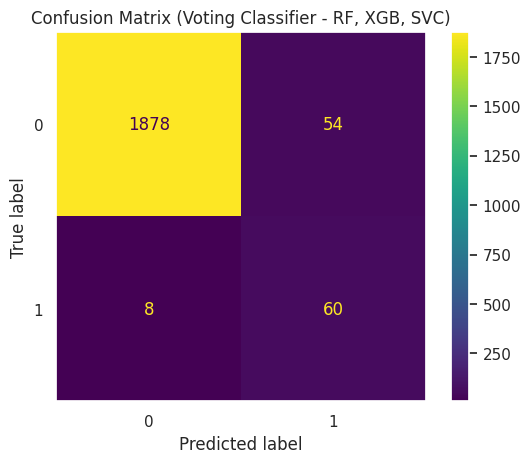

In [150]:
# Define the estimators ( models to include in the voting classifier)
# This list includes all the tuned scikit-learn models
# Cant do the Neural Network because Keras API !compatible with scikit
estimators = [
    ('rf', grid_search.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('svc', grid_search_svc.best_estimator_),
    # ('dt', grid_search_dt.best_estimator_),
    # ('bagging', grid_search_bagging.best_estimator_),
    # ('lr', pipe_log_reg)
]

voting_clf = VotingClassifier(estimators=estimators)

voting_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the Voting Classifier
print("Classification Report (Voting Classifier):")
print(classification_report(y_test, y_pred_voting))

cm_voting = confusion_matrix(y_test, y_pred_voting)
disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting)
disp_voting.plot()
plt.grid(False)
plt.title("Confusion Matrix (Voting Classifier - RF, XGB, SVC)")
plt.show()

# DO NOT RUN THIS!!
Unless you want to generate 57 different combinations of models and plot their confusion matrices.

In [151]:
# # Define the master list of estimators you want to combine.
# # Add or remove models from this list as needed.
# estimators_to_combine = [
#     ('rf', grid_search.best_estimator_),
#     ('xgb', grid_search_xgb.best_estimator_),
#     ('svc', grid_search_svc.best_estimator_),
#     ('dt', grid_search_dt.best_estimator_),
#     ('bagging', grid_search_bagging.best_estimator_),
#     ('lr', pipe_log_reg)
# ]

# # Loop through all combination lengths (from 2 models up to all models)
# for r in range(2, len(estimators_to_combine) + 1):
#     # Generate all combinations of length r
#     for combo in combinations(estimators_to_combine, r):

#         # Get the list of estimators for the current combination
#         current_estimators = list(combo)
#         model_names = ", ".join([name.upper() for name, model in current_estimators])

#         print(f"\n{'='*20} TESTING COMBINATION: {model_names} {'='*20}")

#         # Initialize and train the Voting Classifier
#         voting_clf = VotingClassifier(estimators=current_estimators, voting='hard') # 'hard' is default
#         voting_clf.fit(X_train, y_train)

#         # Make predictions on the test data
#         y_pred_voting = voting_clf.predict(X_test)

#         # Evaluate the Voting Classifier
#         print(f"\nClassification Report ({model_names}):")
#         print(classification_report(y_test, y_pred_voting))

#         # Create and display the Confusion Matrix
#         cm_voting = confusion_matrix(y_test, y_pred_voting)
#         disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting)
#         disp_voting.plot()
#         plt.title(f"Confusion Matrix (Voting: {model_names})")
#         plt.show()

# Looking into XGBoost

XGBoost outperforms every single other model on recall (but has too many false positives to be efficient)

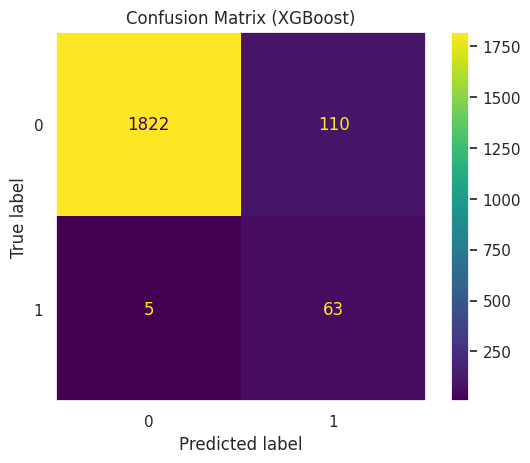

In [152]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title("Confusion Matrix (XGBoost)")
plt.grid(False)
plt.show()

In [153]:
#  Forgot these are required by Dr. Fairclough

# Untuned Random Forest
pipe_rf_untuned = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Untuned Bagging
pipe_bag_untuned = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', BaggingClassifier(random_state=42))
])

# Untuned SVC
pipe_svc_untuned = SklearnPipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True))
])

pipe_rf_untuned.fit(X_train, y_train)
pipe_bag_untuned.fit(X_train, y_train)
pipe_svc_untuned.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(probability=True, random_state=42))])

# One more thing...

In [154]:
model_names = []
train_accuracies = []
test_accuracies = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1s = []
test_f1s = []

def get_predictions(model, X_train, X_test, scaler=None):
    if isinstance(model, SklearnPipeline):
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    elif isinstance(model, tf.keras.models.Sequential):
        # For Neural Network, use scaled data
        if scaler is None:
             raise ValueError("Scaler must be provided for Neural Network predictions.")
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_train_pred_prob = model.predict(X_train_scaled)
        y_test_pred_prob = model.predict(X_test_scaled)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int)
        y_test_pred = (y_test_pred_prob > 0.5).astype(int)
    else:
        # For other models (if I add any), assume direct prediction
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    return y_train_pred, y_test_pred


# Tuned Random Forest
model_names.append('Tuned Random Forest')
y_train_pred_rf, y_test_pred_rf = get_predictions(grid_search.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_rf))
test_accuracies.append(accuracy_score(y_test, y_test_pred_rf))
train_recalls.append(recall_score(y_train, y_train_pred_rf))
test_recalls.append(recall_score(y_test, y_test_pred_rf))
train_precisions.append(precision_score(y_train, y_train_pred_rf))
test_precisions.append(precision_score(y_test, y_test_pred_rf))
train_f1s.append(f1_score(y_train, y_train_pred_rf))
test_f1s.append(f1_score(y_test, y_test_pred_rf))

# Untuned Random Forest
model_names.append('Untuned Random Forest')
y_train_pred_rf_untuned, y_test_pred_rf_untuned = get_predictions(pipe_rf_untuned, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_rf_untuned))
test_accuracies.append(accuracy_score(y_test, y_test_pred_rf_untuned))
train_recalls.append(recall_score(y_train, y_train_pred_rf_untuned))
test_recalls.append(recall_score(y_test, y_test_pred_rf_untuned))
train_precisions.append(precision_score(y_train, y_train_pred_rf_untuned))
test_precisions.append(precision_score(y_test, y_test_pred_rf_untuned))
train_f1s.append(f1_score(y_train, y_train_pred_rf_untuned))
test_f1s.append(f1_score(y_test, y_test_pred_rf_untuned))


# Tuned Bagging Classifier
model_names.append('Tuned Bagging Classifier')
y_train_pred_bag, y_test_pred_bag = get_predictions(grid_search_bagging.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_bag))
test_accuracies.append(accuracy_score(y_test, y_test_pred_bag))
train_recalls.append(recall_score(y_train, y_train_pred_bag))
test_recalls.append(recall_score(y_test, y_test_pred_bag))
train_precisions.append(precision_score(y_train, y_train_pred_bag))
test_precisions.append(precision_score(y_test, y_test_pred_bag))
train_f1s.append(f1_score(y_train, y_train_pred_bag))
test_f1s.append(f1_score(y_test, y_test_pred_bag))

# Untuned Bagging Classifier
model_names.append('Untuned Bagging Classifier')
y_train_pred_bag_untuned, y_test_pred_bag_untuned = get_predictions(pipe_bag_untuned, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_bag_untuned))
test_accuracies.append(accuracy_score(y_test, y_test_pred_bag_untuned))
train_recalls.append(recall_score(y_train, y_train_pred_bag_untuned))
test_recalls.append(recall_score(y_test, y_test_pred_bag_untuned))
train_precisions.append(precision_score(y_train, y_train_pred_bag_untuned))
test_precisions.append(precision_score(y_test, y_test_pred_bag_untuned))
train_f1s.append(f1_score(y_train, y_train_pred_bag_untuned))
test_f1s.append(f1_score(y_test, y_test_pred_bag_untuned))


# Logistic Regression
model_names.append('Logistic Regression')
y_train_pred_lr, y_test_pred_lr = get_predictions(pipe_log_reg, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_lr))
test_accuracies.append(accuracy_score(y_test, y_test_pred_lr))
train_recalls.append(recall_score(y_train, y_train_pred_lr))
test_recalls.append(recall_score(y_test, y_test_pred_lr))
train_precisions.append(precision_score(y_train, y_train_pred_lr))
test_precisions.append(precision_score(y_test, y_test_pred_lr))
train_f1s.append(f1_score(y_train, y_train_pred_lr))
test_f1s.append(f1_score(y_test, y_test_pred_lr))

# XGBoost
model_names.append('XGBoost')
y_train_pred_xgb, y_test_pred_xgb = get_predictions(grid_search_xgb.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_xgb))
test_accuracies.append(accuracy_score(y_test, y_test_pred_xgb))
train_recalls.append(recall_score(y_train, y_train_pred_xgb))
test_recalls.append(recall_score(y_test, y_test_pred_xgb))
train_precisions.append(precision_score(y_train, y_train_pred_xgb))
test_precisions.append(precision_score(y_test, y_test_pred_xgb))
train_f1s.append(f1_score(y_train, y_train_pred_xgb))
test_f1s.append(f1_score(y_test, y_test_pred_xgb))

# SVC
model_names.append('Tuned SVC')
y_train_pred_svc, y_test_pred_svc = get_predictions(grid_search_svc.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_svc))
test_accuracies.append(accuracy_score(y_test, y_test_pred_svc))
train_recalls.append(recall_score(y_train, y_train_pred_svc))
test_recalls.append(recall_score(y_test, y_test_pred_svc))
train_precisions.append(precision_score(y_train, y_train_pred_svc))
test_precisions.append(precision_score(y_test, y_test_pred_svc))
train_f1s.append(f1_score(y_train, y_train_pred_svc))
test_f1s.append(f1_score(y_test, y_test_pred_svc))

# Untuned SVC
model_names.append('Untuned SVC')
y_train_pred_svc_untuned, y_test_pred_svc_untuned = get_predictions(pipe_svc_untuned, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_svc_untuned))
test_accuracies.append(accuracy_score(y_test, y_test_pred_svc_untuned))
train_recalls.append(recall_score(y_train, y_train_pred_svc_untuned))
test_recalls.append(recall_score(y_test, y_test_pred_svc_untuned))
train_precisions.append(precision_score(y_train, y_train_pred_svc_untuned))
test_precisions.append(precision_score(y_test, y_test_pred_svc_untuned))
train_f1s.append(f1_score(y_train, y_train_pred_svc_untuned))
test_f1s.append(f1_score(y_test, y_test_pred_svc_untuned))


# Decision Tree
model_names.append('Decision Tree')
y_train_pred_dt, y_test_pred_dt = get_predictions(grid_search_dt.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_dt))
test_accuracies.append(accuracy_score(y_test, y_test_pred_dt))
train_recalls.append(recall_score(y_train, y_train_pred_dt))
test_recalls.append(recall_score(y_test, y_test_pred_dt))
train_precisions.append(precision_score(y_train, y_train_pred_dt))
test_precisions.append(precision_score(y_test, y_test_pred_dt))
train_f1s.append(f1_score(y_train, y_train_pred_dt))
test_f1s.append(f1_score(y_test, y_test_pred_dt))

# KNN
model_names.append('KNN')
y_train_pred_knn, y_test_pred_knn = get_predictions(grid_search_knn.best_estimator_, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_knn))
test_accuracies.append(accuracy_score(y_test, y_test_pred_knn))
train_recalls.append(recall_score(y_train, y_train_pred_knn))
test_recalls.append(recall_score(y_test, y_test_pred_knn))
train_precisions.append(precision_score(y_train, y_train_pred_knn))
test_precisions.append(precision_score(y_test, y_test_pred_knn))
train_f1s.append(f1_score(y_train, y_train_pred_knn))
test_f1s.append(f1_score(y_test, y_test_pred_knn))

# Neural Network
model_names.append('Neural Network')
# Need the scaler I used for the NN
y_train_pred_nn, y_test_pred_nn = get_predictions(final_boss_nn, X_train, X_test, scaler=scaler_nn)
train_accuracies.append(accuracy_score(y_train, y_train_pred_nn))
test_accuracies.append(accuracy_score(y_test, y_test_pred_nn))
train_recalls.append(recall_score(y_train, y_train_pred_nn))
test_recalls.append(recall_score(y_test, y_test_pred_nn))
train_precisions.append(precision_score(y_train, y_train_pred_nn))
test_precisions.append(precision_score(y_test, y_test_pred_nn))
train_f1s.append(f1_score(y_train, y_train_pred_nn))
test_f1s.append(f1_score(y_test, y_test_pred_nn))

# Voting Classifier
model_names.append('Voting Classifier')
y_train_pred_voting, y_test_pred_voting = get_predictions(voting_clf, X_train, X_test)
train_accuracies.append(accuracy_score(y_train, y_train_pred_voting))
test_accuracies.append(accuracy_score(y_test, y_test_pred_voting))
train_recalls.append(recall_score(y_train, y_train_pred_voting))
test_recalls.append(recall_score(y_test, y_test_pred_voting))
train_precisions.append(precision_score(y_train, y_train_pred_voting))
test_precisions.append(precision_score(y_test, y_test_pred_voting))
train_f1s.append(f1_score(y_train, y_train_pred_voting))
test_f1s.append(f1_score(y_test, y_test_pred_voting))


comparison_frame = pd.DataFrame({
    'Model': model_names,
    'Train_Accuracy': train_accuracies,
    'Test_Accuracy': test_accuracies,
    'Train_Recall': train_recalls,
    'Test_Recall': test_recalls,
    'Train_Precision': train_precisions,
    'Test_Precision': test_precisions,
    'Train_F1': train_f1s,
    'Test_F1': test_f1s,
})

# For predictive maintenance, recall is often the most important metric because
# you really don't want to miss a potential failure (False Negative)
# I refer to this as the "Business Case" (vs. an F1 score or something similar)
comparison_frame_sorted = comparison_frame.sort_values(by='Test_Recall', ascending=False)

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

print(comparison_frame_sorted)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                         Model  Train_Accuracy  Test_Accuracy  Train_Recall  Test_Recall  Train_Precision  Test_Precision  Train_F1   Test_F1
5                      XGBoost        0.947875         0.9425      0.970480     0.926471         0.391369        0.364162  0.557794  0.522822
11           Voting Classifier        0.971500         0.9690      0.981550     0.882353         0.543967        0.526316  0.700000  0.659341
6                    Tuned SVC        0.938875         0.9310      0.970480     0.882353         0.353495        0.315789  0.518227  0.465116
10              Neural Network        0.865000         0.8625      0.974170     0.882353         0.197457        0.183486  0.328358  0.303797
8                Decision Tree        0.970625         0.9635      1.000000     0.838235         0.535573        0.478992  0.697555  0.609626
4          Logistic Regression        0.854500         0.8500      0

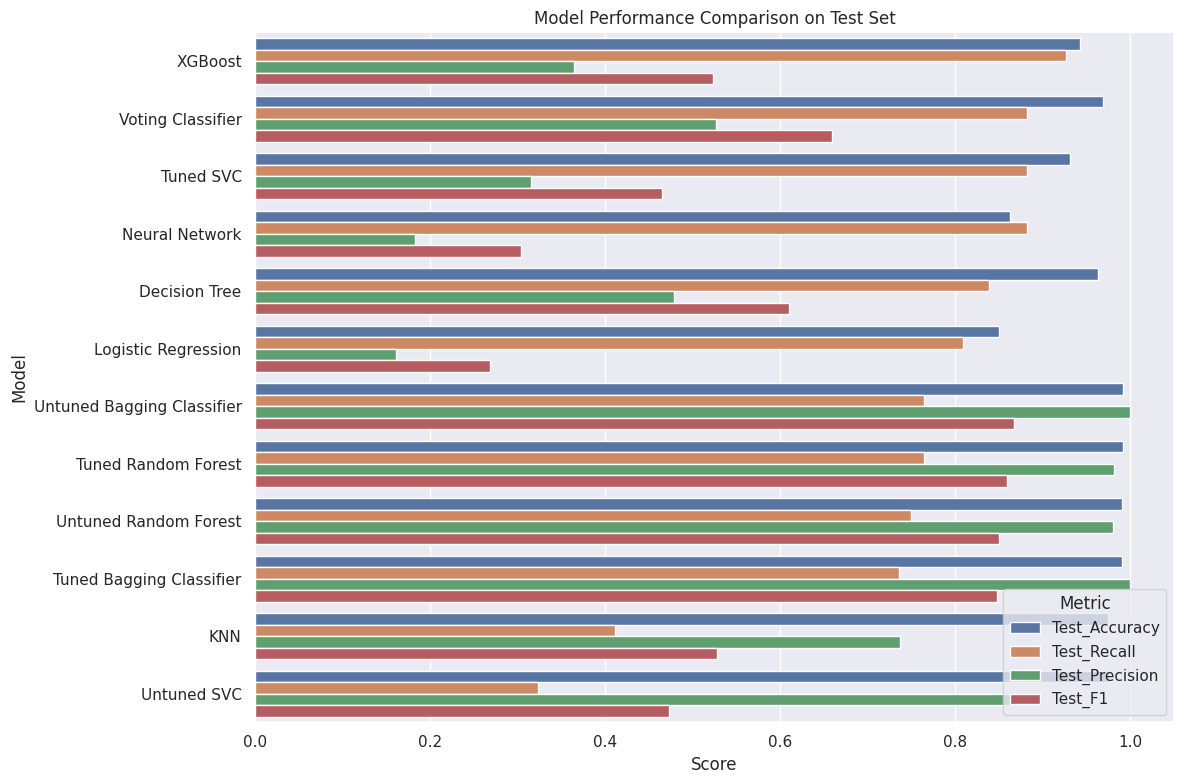

In [155]:
# Reshape the Dataframe for plotting
comparison_melted = comparison_frame_sorted.melt(id_vars='Model',
                                                 value_vars=['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1'],
                                                 var_name='Metric',
                                                 value_name='Score')

# Create the plot for the poster
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Model', hue='Metric', data=comparison_melted)

plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Score')
plt.ylabel('Model')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()